<a href="https://colab.research.google.com/github/lucahuesler/dlv_FindWally/blob/master/notebook_luca_h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Find Wally


## Load libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


# Import TensorFlow and TensorFlow Datasets
%tensorflow_version 1.x
import tensorflow as tf
#tf.compat.v1.enable_eager_execution(
#    config=None, device_policy=None, execution_mode=None)

# Shortcuts to keras if (however from tensorflow)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard 

# Helper libraries
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


## Get data

### Option 1: Load data from drive

The data is stored on a google drive folder. So we first mount the drive to get our input data.

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Now we can define the path to the training and validation data as well as to the annotations

In [0]:
#path_data = '/content/drive/My Drive/dlv_FindWally/data'
#path_train = '/content/drive/My Drive/dlv_FindWally/data/train'
#path_validation = '/content/drive/My Drive/dlv_FindWally/data/validation'
#path_annotations = '/content/drive/My Drive/dlv_FindWally/data/annotations/annotations.csv'

### Option 2: Load data from github

Probably better, so everyone can easily work with the same data.

In [4]:
!git clone https://github.com/lucahuesler/dlv_FindWally.git

Cloning into 'dlv_FindWally'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 99 (delta 31), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (99/99), done.


Now, pathes are a bit different:

In [0]:
path_data = '/content/dlv_FindWally/data/data'
path_train = '/content/dlv_FindWally/data/data/train'
path_validation = '/content/dlv_FindWally/data/data/validation'
path_annotations = '/content/dlv_FindWally/data/data/annotations'

### Convert annotations to xml

This is necessary so we can use the function  `extract_boxes` in WallyDataset class to draw the boxes from the annotations (see step 5)

In [6]:
# convert csv to xml
!pip3 install dicttoxml
from dicttoxml import dicttoxml

# read annotations from csv
annotations = pd.read_csv(os.path.join(path_annotations, 'annotations.csv'))


# convert df to dict
annotations_dict = annotations.to_dict(orient="records")

# Converting the dataframe to XML
# Then save it to file
annotations_xml = dicttoxml(annotations_dict).decode()
with open(os.path.join(path_annotations, "annotations.xml"), "w+") as f:
    f.write(annotations_xml)

  Created wheel for dicttoxml: filename=dicttoxml-1.7.4-cp36-none-any.whl size=17452 sha256=29f69482939cffac87e00a0509a8af788099ab16c93a7d0a8a39df746291a6b5
  Stored in directory: /root/.cache/pip/wheels/62/4f/a3/afd4a68f5add45a668c14efa53b64d5cffb2be6bacf993c151
Successfully built dicttoxml


## Visual inspection of images

Let's have a look at some examples of the train and validation images.

In [0]:
# Shortcut for displaying images
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()

In [8]:
print(os.listdir(path_train))
len(os.listdir(path_train))

['15.jpg', '1.jpg', '18.jpg', '14.jpg', '23.jpg', '19.jpg', '2.jpg', '13.jpg', '20.jpg', '11.jpg', '7.jpg', '8.jpg', '17.jpg', '5.jpg', '21.jpg', '16.jpg', '9.jpg', '3.jpg', '4.jpg', '12.jpg', '22.jpg', '10.jpg']


22

In [9]:
len(os.listdir(path_validation))

4

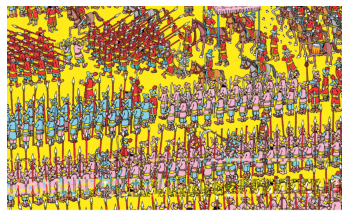

In [10]:
os.chdir(path_train)
img = mpimg.imread('1.jpg')
np.shape(img)

plot_img(img)

## Transfer learning
The idea is to take the pretrained [Mask R-CNN](https://github.com/matterport/Mask_RCNN) model developed by Matterport and add a new class which detects *Wally*.

A similar process for balloon's is described [here](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon).

See also this [blog post](https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d).

### Step 1: Clone Matterport Mask R-CNN
We first get a git clone from where we can start to build our own model.

In [11]:
# clone into top folder of project
os.chdir('/content/dlv_FindWally/')
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.82 MiB | 32.47 MiB/s, done.
Resolving deltas: 100% (568/568), done.


### Step 2: Install the Mask R-CNN Library

The library can be installed directly via pip.

Change directory into the Mask_RCNN directory and run the installation script.

From the command line, type the following:

In [12]:
import os
os.chdir('./Mask_RCNN')
!pip3 install -r requirements.txt
!python3 setup.py install 

     |████████████████████████████████| 204kB 10.4MB/s 
     |████████████████████████████████| 163kB 17.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=ed53fe398e6f602f1c5fc8b90deb1943be230d5f8b69296f7361af7be3b53d47
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn

In [13]:
# check installation
!pip3 show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 


### Step 3: Import additional libraries mrcnn

Those used in https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d?gi=c63617215f41

In [14]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN

import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time

from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree

Using TensorFlow backend.


### Step 4: Create custom config class for wally

In [0]:
class WallyMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 1+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    
    # Learning rate
    LEARNING_RATE=0.006
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

In [16]:
config = WallyMaskRCNNConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [17]:
annotations_xml

'<?xml version="1.0" encoding="UTF-8" ?><root><item type="dict"><filename type="str">1.jpg</filename><width type="int">2048</width><height type="int">1251</height><class type="str">waldo</class><xmin type="int">706</xmin><ymin type="int">513</ymin><xmax type="int">743</xmax><ymax type="int">562</ymax></item><item type="dict"><filename type="str">10.jpg</filename><width type="int">1600</width><height type="int">980</height><class type="str">waldo</class><xmin type="int">715</xmin><ymin type="int">157</ymin><xmax type="int">733</xmax><ymax type="int">181</ymax></item><item type="dict"><filename type="str">11.jpg</filename><width type="int">2828</width><height type="int">1828</height><class type="str">waldo</class><xmin type="int">460</xmin><ymin type="int">1530</ymin><xmax type="int">482</xmax><ymax type="int">1557</ymax></item><item type="dict"><filename type="str">12.jpg</filename><width type="int">1276</width><height type="int">1754</height><class type="str">waldo</class><xmin type="i

In [18]:
os.getcwd()


'/content/dlv_FindWally/Mask_RCNN'

### Step 5: Build the custom wally data set class.

In [0]:
class WallyDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "wally")
        
        # define data locations for images and annotations
        if is_train==False:
          images_dir = dataset_dir + '/validation'
        else:
          images_dir = dataset_dir + '/train'
        print(images_dir)  
        annotations_dir = dataset_dir + '/annotations'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(images_dir):
            
            # extract image id
            image_id = filename[:-4]
            
            # skip bad images
            #if image_id in ['00090']:
            #    continue
            # skip all images after 150 if we are building the train set
            #if is_train and int(image_id) >= 150:
            #    continue
            # skip all images before 150 if we are building the test/val set
            #if not is_train and int(image_id) < 150:
            #    continue
            
            # setting image file
            img_path = images_dir + filename
            
            # setting annotations file
            ann_path = annotations_dir + image_id + '.xml'
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)# extract bounding boxes from an annotation file
    
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height# load the masks for an image

    def extract_boxes_csv(self, filename):

      boxes = list()
      xmin = annotations[annotations['filename']==filename]['xmin']
      ymin = annotations[annotations['filename']==filename]['ymin']
      xmax = annotations[annotations['filename']==filename]['xmax']
      ymax = annotations[annotations['filename']==filename]['ymax']
      coors = [xmin, ymin, xmax, ymax]
      boxes.append(coors)

      # extract image dimensions
      width = annotations[annotations['filename']==filename]['width']
      height = annotations[annotations['filename']==filename]['height']
      return boxes, width, height # load the masks for an image

    def load_mask(self, image_id):
      """
      Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
      """

      # get details of image
      info = self.image_info[image_id]
      
      # define anntation  file location
      path = info['annotation']
      
      # load XML
      boxes, w, h = self.extract_boxes_csv(path)
      
      # create one array for all masks, each on a different channel
      masks = zeros([h, w, len(boxes)], dtype='uint8')
      
      # create masks
      class_ids = list()
      for i in range(len(boxes)):
          box = boxes[i]
          row_s, row_e = box[1], box[3]
          col_s, col_e = box[0], box[2]
          masks[row_s:row_e, col_s:col_e, i] = 1
          class_ids.append(self.class_names.index('wally'))
      return masks, asarray(class_ids, dtype='int32')# load an image reference
     

    def image_reference(self, image_id):
      """
      Return the path of the image.
      """
      
      info = self.image_info[image_id]
      print(info)
      return info['path']

In [21]:
filename = '21.jpg'
image_id = filename[:-4]
image_id

'21'

In [0]:


def extract_boxes(self, filename):
    
    # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = list()
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
    
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height# load the masks for an imag

In [23]:
def extract_boxes_csv(filename):
  boxes = list()
  xmin = annotations[annotations['filename']==filename]['xmin']
  ymin = annotations[annotations['filename']==filename]['ymin']
  xmax = annotations[annotations['filename']==filename]['xmax']
  ymax = annotations[annotations['filename']==filename]['ymax']
  coors = [xmin, ymin, xmax, ymax]
  boxes.append(coors)

  # extract image dimensions
  width = annotations[annotations['filename']==filename]['width']
  height = annotations[annotations['filename']==filename]['height']
  return boxes, width, height # load the masks for an image

test = extract_boxes_csv('1.jpg')
test

([[0    706
   Name: xmin, dtype: int64, 0    513
   Name: ymin, dtype: int64, 0    743
   Name: xmax, dtype: int64, 0    562
   Name: ymax, dtype: int64]], 0    2048
 Name: width, dtype: int64, 0    1251
 Name: height, dtype: int64)

### Step 6: Prepare the train and validation set

In [27]:
train_set = WallyDataset()
train_set.load_dataset(path_data, is_train=True)
train_set.prepare()
print(f"Number of train images: {len(train_set.image_ids)}")

/content/dlv_FindWally/data/data/train
Number of train images: 22


In [28]:
path_data

'/content/dlv_FindWally/data/data'

In [29]:
# load an image
image_id = 20
image = train_set.load_image(image_id)
print(image.shape)
print(train_set.class_ids)
# load image mask
mask, class_ids = train_set.load_mask(image_id)

print(mask.shape)
print(class_ids)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.4)

pyplot.show()



FileNotFoundError: ignored

In [30]:
validation_set = WallyDataset()
validation_set.load_dataset(path_data, is_train=False)
validation_set.prepare()
print(f"Number of validation images: {len(validation_set.image_ids)}")

/content/dlv_FindWally/data/data/validation
Number of validation images: 4


### Step 7:Initialize Mask R-CNN model for “training” using the Config instance that we created

Requirements: Python 3.4, TensorFlow 1.3, Keras 2.0.

In [31]:
# obviously uses tensorflow v1.x
print("Loading Mask R-CNN model...")
tf.compat.v1.disable_eager_execution()
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

#Probably the problem are the versions. See requirements in that file: https://github.com/matterport/Mask_RCNN/blob/master/README.md

Loading Mask R-CNN model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


### Step 8: Load weights from COCO

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [34]:
# pretrained weights have to be downloaded and place in the path defined below
# loaded from gdrive (github only allows uploads < 25MB)
model.load_weights('/content/drive/My Drive/mask_rcnn_coco.h5', by_name=True)

ValueError: ignored

### Step 9: Train with wally pictures


In [36]:
## train heads with higher lr to speedup the learning
from keras.models import load_model
model.train(train_set, validation_set, learning_rate=2*config.LEARNING_RATE, epochs=5, layers='heads')

history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: ./maskrcnn_config20200426T1748/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

AttributeError: ignored

## VGG16

### Load and compile VGG16

In [0]:
# General imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Shortcuts to keras if (however from tensorflow)
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard 

# Shortcut for displaying images
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()
    
# The target image size can be fixed here (quadratic)
# The ImageDataGenerator() automatically scales the images accordingly (aspect ratio is changed)
image_size = 150

In [0]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))

You pass three arguments to the constructor:

- `weights` specifies the weight checkpoint from which to initialize the model.

- `include_top` refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1000 classes from ImageNet. Because we intend to use our own densely connected classifier you don't need to include it.

- `input_shape` is the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, the network will be able to process inputs of any size.

In [0]:
# predict_generator requires compilation
vgg16.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

vgg16.summary()

### Train with Wally

In [0]:
# These are the class names; this defines the ordering of the classes
class_names = ["wally"]

# No augmentation 
datagen = ImageDataGenerator(rescale=1./255)

batch_size = 20
num_train_images = 480
num_valid_images = 80
num_classes = 8

generator = datagen.flow_from_directory(
        path_train,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        classes=class_names,
        # this means our generator will only yield batches of 
        # data, no labels
        class_mode=None,  
        # our data will be in order
        shuffle=False)  

# the predict_generator method returns the CNN activation maps 
# of the last layer
bottleneck_features_train = vgg16.predict_generator(generator, 
                                                    num_train_images // batch_size)

print("Shape of last layer feature map of training dataset:", bottleneck_features_train.shape)

# save the output as a Numpy array
np.save('./models/bottleneck_features_train.npy', 
        bottleneck_features_train)

generator = datagen.flow_from_directory(
        './validation',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        classes=class_names,
        class_mode=None,
        shuffle=False)

bottleneck_features_validation = vgg16.predict_generator(generator, 
                                                         num_valid_images // batch_size)

np.save('./models/bottleneck_features_validation.npy', bottleneck_features_validation)

print("Shape of last layer feature map of validation dataset:", bottleneck_features_validation.shape

## Testing